Use new peaks, use mass defect formula, consider adding error to determine if avg distance from whole number increases or decreases.
+ IMport new peaks, incorporate into dataframe
+ calculate avg dist from whole number 
    + do the same for subsections of spectrum
+ plot hist / normal curve of dist for avg dist whole num
+ begin classification by adding error and measuring change in avg dist whole num
+ use dist to do p or t probability tests

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sys import path
%matplotlib inline

In [3]:
path.insert(0, '/Users/warren/Desktop/Phi/TOF_ML/src/')
from data_generator import DataGenerator
from model_trainer import ModelTrainer

In [2]:
dg = DataGenerator('./data/classification_cas_data.csv')
norm_data = dg.df()

In [3]:
import os
dir = './SpectraCsvFiles/'
channels = []
intensities = []
names = []
for csv in os.listdir(dir):
    data = pd.read_csv(dir + csv, names=['channels', 'intensities'])
    channels.append(data['channels'])
    intensities.append(data['intensities'])
    names.append(csv[0:-3] + 'cas')

In [4]:
data = pd.DataFrame(list(zip(channels, intensities, names)), columns=['precise_channels', 'precise_intensities', 'file_name'])
norm_data.sort_values('file_name', inplace=True)
data.sort_values('file_name', inplace=True)
dg.set_df(pd.merge(data, norm_data, on='file_name'))
norm_data = dg.df()

In [5]:
def get_precise_peaks(df):
    all_peaks = []
    for row in df.iterrows():
        chans = row[1]['precise_channels'][row[1]['precise_intensities'] > 0]
        intens = row[1]['precise_intensities'][row[1]['precise_intensities'] > 0]
        all_peaks.append(list(zip(chans, intens)))
    return all_peaks

In [6]:
peaks = get_precise_peaks(norm_data)
norm_data['peaks'] = peaks
dg.set_df(norm_data)
norm_data = dg.calibrated_df()

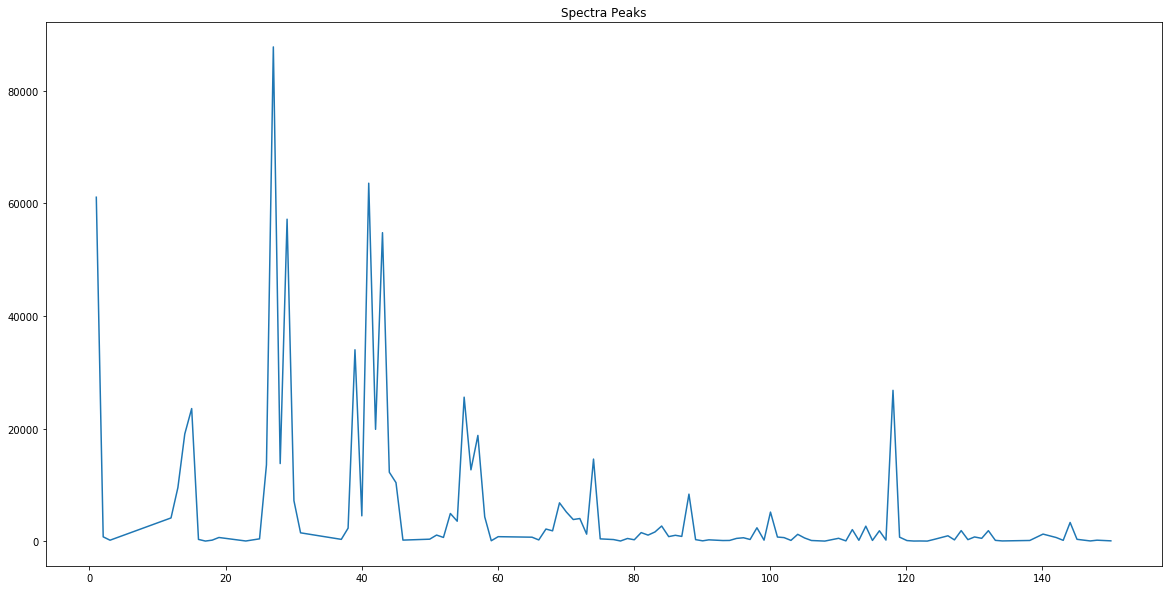

In [68]:
plt.figure(figsize=(20,10))
plt.title('Spectra Peaks')
plt.plot(np.array(norm_data['masses'][8]), np.array(norm_data['intensities'][8]))

In [8]:
def get_dist_whole_num(peak):
    return abs(peak - round(peak))
def get_avg(series, func=get_dist_whole_num, args=None):
    avg_dists = []
    for peaks in series:
        avg_dist = 0
        for i, peak in enumerate(peaks):
            dist = 0
            if args:
                dist = func(peak, *args)
            else:
                dist=func(peak)
            
            avg_dist += dist
        avg_dists.append(avg_dist / len(peaks))
    return avg_dists

## Get Non-Error Distribution Stats

In [9]:
avg_dists = get_avg(norm_data['masses'])

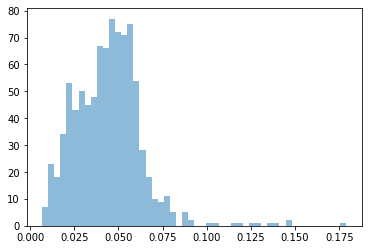

In [10]:
plt.hist(avg_dists, bins=50, alpha=0.5, label='Calibrated')
plt.show()

In [11]:
from scipy.stats import tmean, tstd
non_error_mean = tmean(avg_dists)
non_error_std = tstd(avg_dists)
trim_ne_mean = tmean(avg_dists, limits=(0, .1))
trim_ne_std = tstd(avg_dists, limits=(0, .1))
print('mean:' + str(non_error_mean))
print('std: ' + str(non_error_std))
print('tmean:' + str(trim_ne_mean))
print('tstd: ' + str(trim_ne_std))

mean:0.04412487053126639
std: 0.01882393772633861
tmean:0.043056576222135455
tstd: 0.016107786176335778


## Get Error Distribution Stats

In [4]:
from data_transformation import add_error
slope = norm_data['Mass/Time'].apply(add_error, args=(2, 2, 1))
offset = norm_data['MassOffset'].apply(add_error, args=(2, 2, 1))

In [5]:
from data_transformation import mass_formula
def get_error_masses(dataframe, avgs_only=True, func=get_dist_whole_num, args=None):
    mass_lists = []
    slopes = []
    offsets = []
    slope_errs = []
    off_errs = []
    for row in dataframe.iterrows():
        slope, slope_err = add_error(row[1]['Mass/Time'], 2, 2, 1)
        offset, off_err = add_error(row[1]['MassOffset'], 2, 2, 1)
        slopes.append(slope)
        offsets.append(offset)
        slope_errs.append(slope_err)
        off_errs.append(off_err)
        spec = row[1]['SpecBinSize']
        time = row[1]['StartFlightTime']
        masses = []
        for tup in row[1]['peaks']:
            masses.append(mass_formula(tup[0], spec, time, slope, offset))
        mass_lists.append(masses)
    avgs = get_avg(mass_lists, func=func, args=args)
    if avgs_only:
        return avgs
    return mass_lists, avgs, off_errs, slope_errs

In [14]:
fifty_avgs = []
for _ in range(100):
    fifty_avgs += get_error_masses(norm_data)

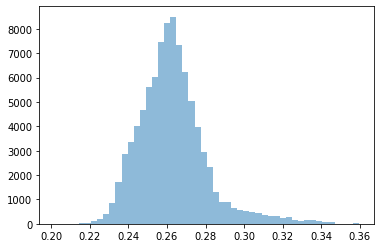

In [15]:
plt.hist(fifty_avgs, bins=50, alpha=0.5, label='Calibrated')
plt.show()

In [16]:
error_mean = tmean(fifty_avgs)
error_std = tstd(fifty_avgs)
trim_e_mean = tmean(fifty_avgs, limits=(0, .3))
trim_e_std = tstd(fifty_avgs, limits=(0, .3))
print('mean:' + str(error_mean))
print('std: ' + str(error_std))
print('tmean:' + str(trim_e_mean))
print('tstd: ' + str(trim_e_std))

mean:0.26291735896434393
std: 0.017929997111851483
tmean:0.26054632366723146
tstd: 0.01400878293361103


## Show Distributions in Training Data

In [17]:
err_data = dg.calibrated_df(error=True)

2.0 2.0


In [18]:
err_data.head()

,precise_channels,precise_intensities,file_name,Mass/Time,MassOffset,StartFlightTime,SpecBinSize,channels,peaks,target,err_prop_slope,err_prop_offset,mass_channels,masses,intensities
0,0 2645.71516 1 3506.21009 2 ...,0 73869 1 1234 2 130 3 ...,0106301.cas,0.387425,-0.275047,0.0,1.248,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(2645.71516, 73869), (3506.21009, 1234), (416...",1,0.000000,0.000000,"[2645.71516, 3506.21009, 4163.61686, 6044.9434...","[1.00836496284447, 2.017050037750175, 3.020955...","[73869, 1234, 130, 340, 807, 4157, 8958, 10845..."
1,0 2648.38807 1 3510.15457 2 ...,0 49864 1 1034 2 32 3 ...,0107316.cas,0.383767,-0.275715,0.0,1.248,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(2648.38807, 49864), (3510.15457, 1034), (416...",0,-0.009217,-0.009296,"[2648.38807, 3510.15457, 4167.1943200000005, 7...","[0.985468336146573, 1.97527069082725, 2.958836...","[49864, 1034, 32, 4696, 8248, 13993, 17903, 22..."
2,0 0.0 1 0.0 2 0.0 3 0.0 4 ...,0 0 1 0 2 0 3 0 4 0 ...,0110203.cas,0.380855,-0.273099,0.0,4.992,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(1973.72345, 23371), (2049.2615, 74777), (212...",0,0.005059,0.007688,"[1973.72345, 2049.2615, 2122.04677, 2190.87428...","[12.106192837816542, 13.126204194768818, 14.14...","[23371, 74777, 10487, 972, 12372, 9145, 39, 26..."
3,0 672.01357 1 891.85035 2 106...,0 34399 1 304 2 45 3 ...,0110212.cas,0.383045,-0.267257,0.0,4.992,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(672.0135700000001, 34399), (891.85035, 304),...",0,0.009884,-0.009514,"[672.0135700000001, 891.85035, 1061.407, 1970....","[1.0357993262323986, 2.068148920999925, 3.1057...","[34399, 304, 45, 2223, 3521, 5205, 6509, 99, 1..."
4,0 2727.76914 1 3595.33615 2 ...,0 42995 1 349 2 151 3 ...,0116511.cas,0.383481,-0.302161,0.0,1.248,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(2727.76914, 42995), (3595.33615, 349), (4265...",1,0.000000,0.000000,"[2727.76914, 3595.33615, 4265.84626, 7867.4968...","[1.0066220926515284, 2.01216868225212, 3.02552...","[42995, 349, 151, 17910, 9536, 17609, 29604, 5..."


In [19]:
err_data['avg_dist_whole_num'] = get_avg(err_data['masses'])

In [20]:
def plot_error_hists(low, high, pos=-1, func=get_dist_whole_num, args=None):
    df = dg.calibrated_df(error=True, low_proportion=low, high_proportion=high)
    df['avg_dist'] = get_avg(df['masses'], func, args)
    if pos==1:
        df = df[df['avg_dist'] >=0]
    elif pos==0:
        df = df[df['avg_dist'] <0]
    plt.hist(df['avg_dist'][df['target']==1], bins=50, alpha=0.5, label='Calibrated')
    plt.hist(df['avg_dist'][df['target']==0], bins=50, alpha=0.5, label='Error')
    plt.legend(loc='upper right')
    plt.show()
    return df

## 0.5% - 1% Error

2.0 2.0


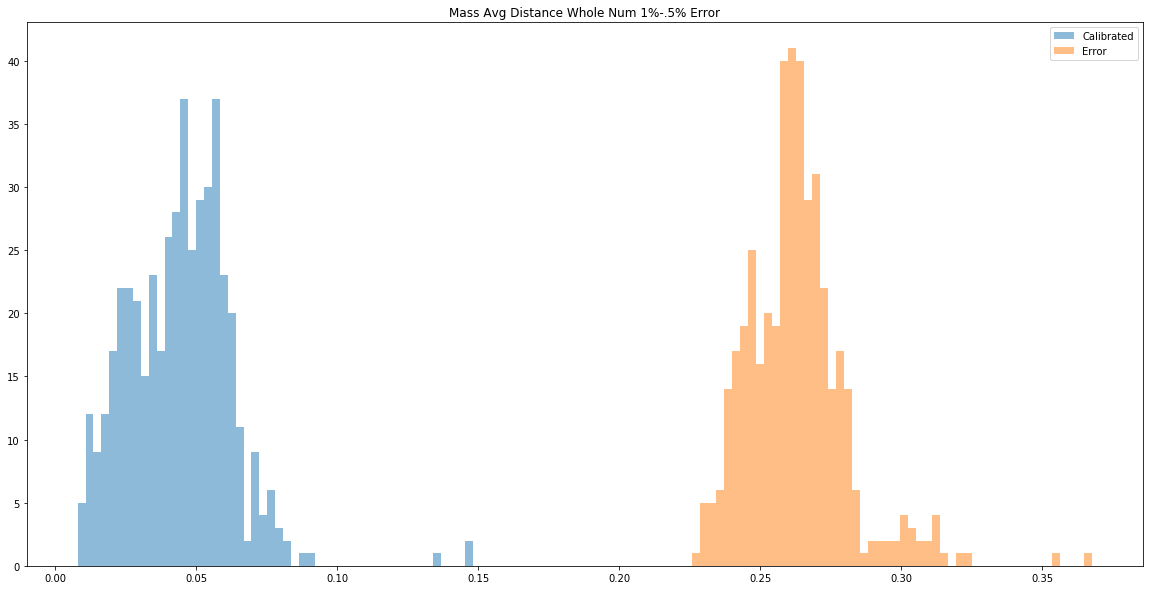

In [71]:
plt.figure(figsize=(20, 10))
plt.title('Mass Avg Distance Whole Num 1%-.5% Error')
test = plot_error_hists(0.005, .01)

## 0.05% .1% Error

2.9999999999999996 1.9999999999999982


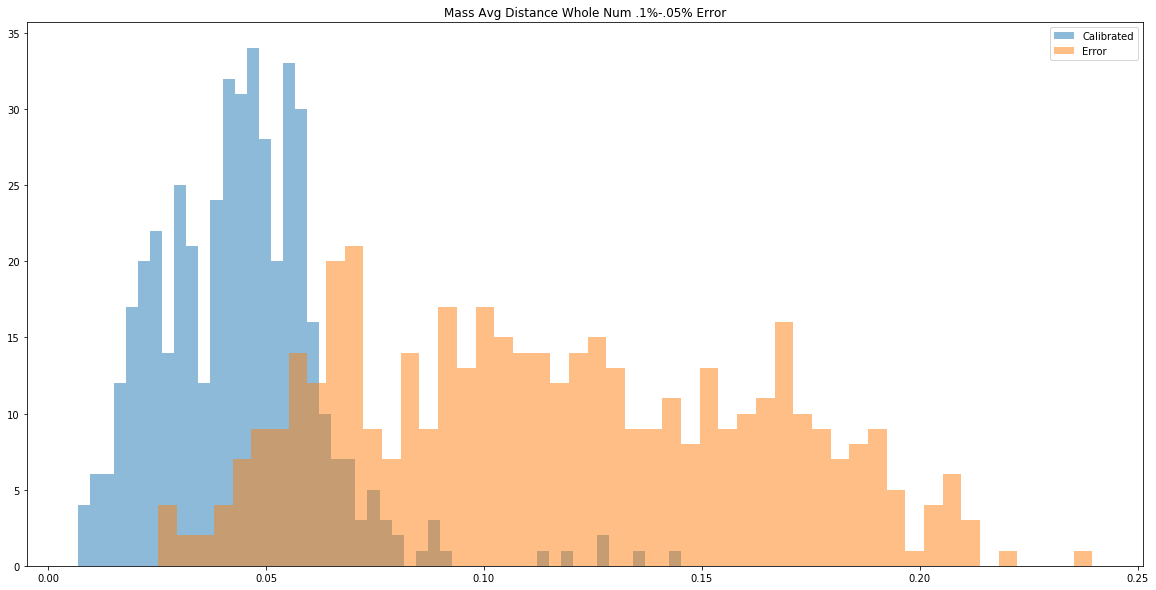

In [72]:
plt.figure(figsize=(20, 10))
plt.title('Mass Avg Distance Whole Num .1%-.05% Error')
test = plot_error_hists(0.0005, .001)

## 0.005% .01% Error

4.0 2.0


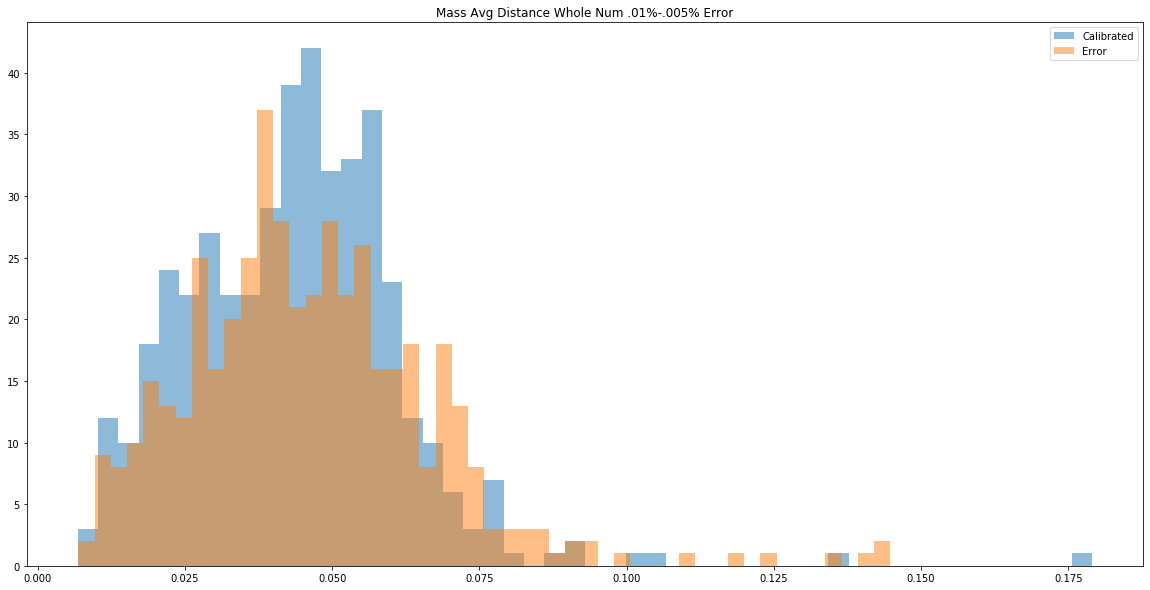

In [73]:
plt.figure(figsize=(20, 10))
plt.title('Mass Avg Distance Whole Num .01%-.005% Error')
test = plot_error_hists(0.00005, .0001)

## 0.0005% .001% Error

5.0 2.0


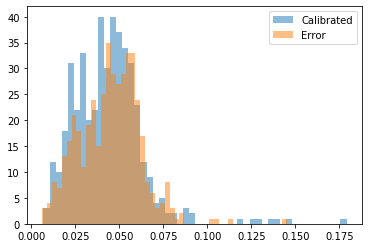

In [24]:
test = plot_error_hists(0.000005, .00001)

## Improve Error Data Using Mass Defects

In [25]:
elements = []
spots = []
freqs = []
with open('./Elements.txt') as file:
    for line in file.readlines():
        element_spots = []
        element_freqs = []
        sections = line.split('(')
        elements.append(sections[0].split()[2])
        for tup in sections[1:]:
            nums = tup.split(',')
            element_spots.append(float(nums[0]))
            element_freqs.append(float(nums[1].split(')')[0]))
        spots.append(element_spots)
        freqs.append(element_freqs)

In [26]:
isotope_data = pd.DataFrame(list(zip(elements, spots, freqs)), columns=['Element', 'Isotope Masses', 'Isotope Frequencies'])

In [27]:
nom_masses = [num for num in range(266)]

In [28]:
for masses in isotope_data['Isotope Masses']:
    for mass in masses:
        if mass < nom_masses[round(mass)]:
            nom_masses[round(mass)] = mass

In [29]:
def get_dist_nom_mass(peak, nom_masses=nom_masses):
    return peak - nom_masses[round(peak)]

## Get Non-Error Nom Mass Data

In [30]:
avg_dists = get_avg(norm_data['masses'], func=get_dist_nom_mass, args=(nom_masses,))

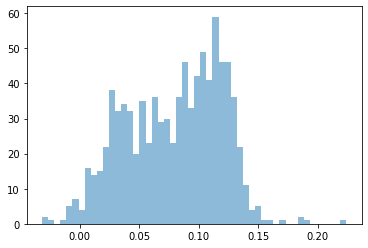

In [31]:
plt.hist(avg_dists, bins=50, alpha=0.5, label='Calibrated')
plt.show()

In [32]:
from scipy.stats import tmean, tstd
non_error_mean = tmean(avg_dists)
non_error_std = tstd(avg_dists)
trim_ne_mean = tmean(avg_dists, limits=(0, .1))
trim_ne_std = tstd(avg_dists, limits=(0, .1))
print('mean:' + str(non_error_mean))
print('std: ' + str(non_error_std))
print('tmean:' + str(trim_ne_mean))
print('tstd: ' + str(trim_ne_std))

mean:0.07923734295094552
std: 0.039844513758444194
tmean:0.057062571610918086
tstd: 0.02714416464713918


## Get Error Nom Mass Data

In [33]:
fifty_avgs = []
for _ in range(100):
    fifty_avgs += get_error_masses(norm_data, func=get_dist_nom_mass, args=(nom_masses, ))

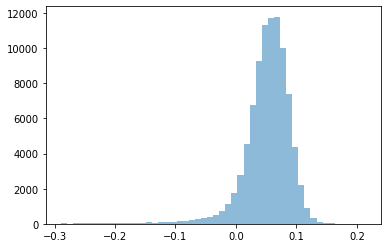

In [34]:
plt.hist(fifty_avgs, bins=50, alpha=0.5, label='Calibrated')
plt.show()

In [35]:
error_mean = tmean(fifty_avgs)
error_std = tstd(fifty_avgs)
trim_e_mean = tmean(fifty_avgs, limits=(0, .3))
trim_e_std = tstd(fifty_avgs, limits=(0, .3))
print('mean:' + str(error_mean))
print('std: ' + str(error_std))
print('tmean:' + str(trim_e_mean))
print('tstd: ' + str(trim_e_std))

mean:0.051185264924343686
std: 0.04075855787951687
tmean:0.058679327187608064
tstd: 0.026217039347636244


## Get Combined Data

## 0.5% 1% Error

2.0 2.0


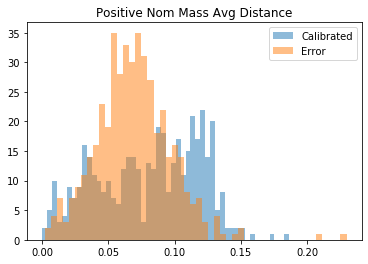

In [36]:
plt.title('Positive Nom Mass Avg Distance')
test = plot_error_hists(.005, .01, pos=1, func=get_dist_nom_mass, args=(nom_masses,))

2.0 2.0


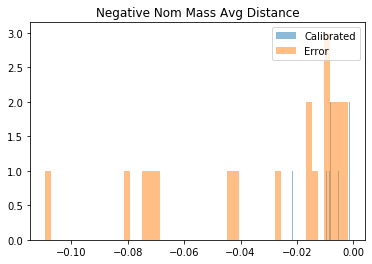

In [37]:

plt.title('Negative Nom Mass Avg Distance')
test = plot_error_hists(.005, .01, pos=0, func=get_dist_nom_mass, args=(nom_masses,))

In [38]:
def get_peaks_below_nom_masses(masses):
    peaks_below = []
    for mass in masses:
        index = round(mass)
        if nom_masses[index] > mass:
            peaks_below.append(mass)
    return peaks_below

In [39]:
err_data['peaks_below'] = err_data['masses'].apply(get_peaks_below_nom_masses)

In [40]:
err_data['num_peaks_below'] = err_data['peaks_below'].apply(len)

In [41]:
err_data[err_data['target'] == 1].describe()

,Mass/Time,MassOffset,StartFlightTime,SpecBinSize,target,err_prop_slope,err_prop_offset,avg_dist_whole_num,num_peaks_below
count,450.000000,450.000000,450.000000,450.000000,450.0,450.0,450.0,450.000000,450.000000
mean,0.323607,-0.221042,2.832146,1.160638,1.0,0.0,0.0,0.046041,9.471111
std,0.092643,0.292686,4.988832,2.205420,0.0,0.0,0.0,0.020461,11.514117
min,0.168588,-1.183953,0.000000,0.138000,1.0,0.0,0.0,0.006925,0.000000
25%,0.172464,-0.511546,0.000000,0.138000,1.0,0.0,0.0,0.033079,2.000000
50%,0.378997,-0.000187,0.000000,0.138000,1.0,0.0,0.0,0.046196,5.000000
75%,0.379326,-0.000016,5.596250,1.250000,1.0,0.0,0.0,0.056409,11.000000
max,0.462456,0.001710,21.571000,20.000000,1.0,0.0,0.0,0.179073,74.000000


In [42]:
err_data[err_data['target'] == 0].describe()

,Mass/Time,MassOffset,StartFlightTime,SpecBinSize,target,err_prop_slope,err_prop_offset,avg_dist_whole_num,num_peaks_below
count,452.000000,452.000000,452.000000,452.000000,452.0,452.000000,452.000000,452.000000,452.000000
mean,0.313353,-0.245588,3.484218,1.278131,0.0,0.000112,0.000426,0.264509,46.070796
std,0.097825,0.293296,5.603416,2.619461,0.0,0.007629,0.007586,0.018614,15.534650
min,0.167664,-1.193773,-0.929000,0.138000,0.0,-0.009983,-0.009938,0.230416,3.000000
25%,0.173290,-0.515688,0.000000,0.138000,0.0,-0.007472,-0.007089,0.253057,36.000000
50%,0.376925,-0.000364,0.000000,0.207000,0.0,0.005097,0.005226,0.261836,50.000000
75%,0.381280,-0.000018,7.139000,1.250000,0.0,0.007655,0.007583,0.271635,58.000000
max,0.466890,0.000571,21.434000,20.000000,0.0,0.009994,0.009998,0.367185,82.000000


In [43]:
def get_avg_p_below(n_p_below):
    avg = 0
    for peak in n_p_below:
        avg += abs(peak - round(peak)) / len(n_p_below)
    return avg

In [44]:
err_data['avg_p_below_dist'] = err_data['peaks_below'].apply(get_avg_p_below)

In [45]:
def get_peaks_near_nom_masses(masses):
    dists = []
    for mass in masses:
        index = round(mass)
        dists.append(mass - nom_masses[index])
    peaks_near = [x for _,x in sorted(zip(dists,masses))]
    return peaks_near[0:20], sorted(dists)[0:20]

In [46]:
peaks, dists = get_peaks_near_nom_masses(err_data['masses'][6])

In [47]:
rows = []
for row in err_data.iterrows():
    peaks, dists = get_peaks_near_nom_masses(row[1]['masses'])
    rows.append(peaks+dists+[row[1]['avg_p_below_dist'], row[1]['num_peaks_below'], row[1]['target']])

In [48]:
cols = ['peak' + str(x) for x in range(20)] + ['dist' + str(x) for x in range(20)] + ['avg_dist_below_nom_mass', 'num_peaks_below', 'target']
training_data = pd.DataFrame(rows, columns=cols)

In [49]:
training_data.head()

,peak0,peak1,peak2,peak3,peak4,peak5,peak6,peak7,peak8,peak9,...,dist13,dist14,dist15,dist16,dist17,dist18,dist19,avg_dist_below_nom_mass,num_peaks_below,target
0,22.965170,27.956957,23.975271,16.991857,11.993457,19.987716,24.981771,39.958432,29.970185,28.975201,...,0.002979,0.005414,0.008365,0.010391,0.010440,0.011734,0.013039,0.024398,10.0,1.0
1,25.514156,28.515970,24.527927,29.521038,26.534203,23.540391,22.563759,85.508745,144.562253,144.562253,...,-0.346563,-0.332023,-0.312204,-0.299507,-0.298429,-0.287387,-0.283462,0.281385,66.0,0.0
2,48.513106,49.518487,50.549139,51.572023,60.591774,59.626897,75.766433,12.106193,13.126204,16.142469,...,0.165403,0.182022,0.250820,0.264237,0.271314,0.281075,0.290881,0.408877,7.0,0.0
3,25.532765,69.509769,26.577044,113.512697,70.541552,119.519877,120.526302,27.608824,28.613292,71.568010,...,-0.312842,-0.308506,-0.305935,-0.301155,-0.288546,-0.284090,-0.249137,0.283061,47.0,0.0
4,11.993043,22.988762,12.999104,24.986416,19.004682,1.006622,14.009482,2.012169,46.972544,15.021373,...,0.031172,0.032894,0.033464,0.033839,0.038115,0.040059,0.045538,0.006364,3.0,1.0


In [50]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
models = [RandomForestClassifier, LGBMClassifier, XGBClassifier]
training_data.dropna(inplace=True)
X=training_data.drop('target', axis=1)
y=training_data['target']
trainer = ModelTrainer(models, X, y, names=['RFC', 'LGBM', 'XGB'])

In [51]:
accs, index_pred = trainer.kfold_models(k=5, seed=60)
accs

/Users/warren/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/warren/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/warren/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/warren/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/warren/opt/anacon

[0.9921787709497207, 0.994413407821229, 0.9921787709497207]

In [52]:
# random forest parameters
n_estimators = [75, 100, 125]
criterion = ['gini', 'entropy']
max_depth = [None, 3, 6]
rfc_params = [n_estimators, criterion, max_depth]
rfc_names = ['n_estimators', 'criterion', 'max_depth']

In [53]:
# lgbm parameters
boosting_type = ['gbdt', 'goss', 'dart']
num_leaves = [31]
max_depth = [-1, 3, 6]
learning_rate = [.1, .3, .01]
n_estimators = [75, 100, 125]
lgbm_parameters = [boosting_type, num_leaves, max_depth, learning_rate, n_estimators]
lgbm_names = ['boosting_type', 'num_leaves', 'max_depth', 'learning_rate', 'n_estimators']

In [54]:
#xgboost parameters
booster = ['gbtree', 'dart']
eta = [0.3, .1, .01]
max_depth = [3, 6, 31]
xgb_params = [booster, eta, max_depth]
xgb_names = ['booster', 'eta', 'max_depth']

In [55]:
results = trainer.model_optimizer([rfc_params, lgbm_parameters, xgb_params], [rfc_names, lgbm_names, xgb_names])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

### Options
+ At this point there are a lot of options
+ These features are highly succeful at 1% error but we must test lower error, check feature importances and eliminate useless features
+ Need to incorporate the use of adding or subtracting 

In [62]:
max(results['RFC accs'][0])

0.995977653631285

In [63]:
index = results['RFC accs'][0].index(max(results['RFC accs'][0]))
results['RFC params'][0][index]

{'n_estimators': 125, 'criterion': 'entropy', 'max_depth': None}

In [64]:
max(results['LGBM accs'][0])

0.9955307262569828

In [65]:
index = results['LGBM accs'][0].index(max(results['LGBM accs'][0]))
results['LGBM params'][0][index]

{'boosting_type': 'goss',
 'num_leaves': 31,
 'max_depth': 3,
 'learning_rate': 0.1,
 'n_estimators': 100}

In [66]:
max(results['XGB accs'][0])

0.9921787709497208

In [67]:
index = results['XGB accs'][0].index(max(results['XGB accs'][0]))
results['XGB params'][0][index]

{'booster': 'gbtree', 'eta': 0.3, 'max_depth': 3}

In [189]:
# random forest parameters 2
n_estimators = [136, 135, 137]
criterion = ['gini']
max_depth = [None]
rfc_params = [n_estimators, criterion, max_depth]
rfc_names = ['n_estimators', 'criterion', 'max_depth']

In [190]:
# lgbm parameters 2
boosting_type = ['dart']
num_leaves = [20, 25, 27]
max_depth = [5]
learning_rate = [.1]
n_estimators = [100]
lgbm_parameters = [boosting_type, num_leaves, max_depth, learning_rate, n_estimators]
lgbm_names = ['boosting_type', 'num_leaves', 'max_depth', 'learning_rate', 'n_estimators']

In [191]:
#xgboost parameters 2
booster = ['gbtree']
eta = [.01]
max_depth = [3]
xgb_params = [booster, eta, max_depth]
xgb_names = ['booster', 'eta', 'max_depth']

In [192]:
results = trainer.model_optimizer([rfc_params, lgbm_parameters, xgb_params], [rfc_names, lgbm_names, xgb_names])

In [193]:
print(max(results['XGB accs'][0]))
index = results['XGB accs'][0].index(max(results['XGB accs'][0]))
results['XGB params'][0][index]

0.9932960893854752


{'booster': 'gbtree', 'eta': 0.01, 'max_depth': 3}

In [194]:
print(max(results['LGBM accs'][0]))
index = results['LGBM accs'][0].index(max(results['LGBM accs'][0]))
results['LGBM params'][0][index]

0.9944134078212293


{'boosting_type': 'dart',
 'num_leaves': 20,
 'max_depth': 5,
 'learning_rate': 0.1,
 'n_estimators': 100}

In [195]:
print(max(results['RFC accs'][0]))
index = results['RFC accs'][0].index(max(results['RFC accs'][0]))
results['RFC params'][0][index]

0.9958286778398509


{'n_estimators': 137, 'criterion': 'gini', 'max_depth': None}

In [215]:
lgbm_params = {'boosting_type': 'dart',
 'num_leaves': 20,
 'max_depth': 5,
 'learning_rate': 0.1,
 'n_estimators': 100}
rfc_params = {'n_estimators': 137, 'criterion': 'gini', 'max_depth': None}
xgb_params = {'booster': 'gbtree', 'eta': 0.01, 'max_depth': 3}
accs, index_pred = trainer.kfold_models(k=5, seed=35, model_params=[rfc_params, lgbm_params, xgb_params])

In [216]:
accs

[0.9955307262569832, 0.994413407821229, 0.993296089385475]

In [271]:
err_data.dropna().loc[training_data.dropna().index][(err_data.loc[training_data.dropna().index]['target'] != [pred for ind, pred in index_pred[0]])]

,precise_channels,precise_intensities,file_name,Mass/Time,MassOffset,StartFlightTime,SpecBinSize,channels,peaks,target,err_prop_slope,err_prop_offset,mass_channels,masses,intensities,avg_dist_whole_num,peaks_below,num_peaks_below,avg_n_p_below_dist,avg_p_below_dist
33,0 717.22435 1 864.20451 2 102...,0 63 1 85 2 70 3 118 4 ...,0312206.cas,0.379524,-0.266999,0.000,4.992,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(717.22435, 63), (864.2045099999999, 85), (10...",1,0.000000,0.000000,"[717.22435, 864.2045099999999, 1023.1614800000...","[1.1921198410700267, 1.8777454877087447, 2.793...","[63, 85, 70, 118, 70, 96, 67, 38, 106, 98, 112...",0.145308,"[1.8777454877087447, 2.7937976873436288, 3.777...",50,0.205217,0.205217
60,0 772.76732 1 0.00000 2 ...,0 35 1 0 2 0 3 0 4 ...,0522213.cas,0.379076,-0.267436,0.000,5.000,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(772.76732, 35), (1968.12477, 30600), (2043.5...",1,0.000000,0.000000,"[772.76732, 1968.12477, 2043.5836600000002, 21...","[1.433413080809456, 11.99174795799143, 13.0027...","[35, 30600, 10110, 440, 193, 269578, 25561, 84...",0.148060,"[11.99174795799143, 15.978455914383769, 16.990...",36,0.145978,0.145978
126,0 0.00000 1 3217.37255 2 ...,0 0 1 38 2 0 3 0 4 ...,1006307.cas,0.384464,-0.291297,0.000,1.248,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(3217.37255, 38), (7879.918459999999, 130368)...",0,0.006397,-0.007464,"[3217.37255, 7879.918459999999, 8179.989009999...","[1.5685932261947402, 12.177153991772714, 13.20...","[38, 130368, 270304, 24754, 535, 683609, 14984...",0.329851,"[1.5685932261947402, 19.978603750027904, 38.50...",6,0.368993,0.368993
708,0 0.00000 1 2805.11469 2 ...,0 0 1 58 2 36 3 ...,KRYTOX02.cas,0.172239,-0.257325,5.594,1.250,"[4, 2, 7, 4, 4, 4, 6, 4, 7, 10, 3, 8, 4, 3, 3,...","[(2805.11469, 58), (4986.58674, 36), (5650.289...",1,0.000000,0.000000,"[2805.11469, 4986.58674, 5650.28974, 6902.4715...","[1.716400741544455, 3.1676239489274454, 3.6966...","[58, 36, 30, 61, 46, 55, 68, 68, 67, 67, 30005...",0.138417,"[1.716400741544455, 3.6966834588112913, 4.8060...",42,0.289121,0.289121


In [275]:
accs

[0.9955307262569832]

In [278]:
importances[0].shape

(895, 42)

In [292]:
def get_kfold_stats(X, y, nsplits, seed=33, models=None):
    '''
    Train models on X, y using kfold cross validation with nsplits. Models 
    defaults to XGBoost, LightGB, and RandomForestClassifier.
    Returns average accuracy of each model and the incorrect predictions
    and indexes of each incorrectly predicted point.

    Arguments -----
    X features / training variables
    y target / training labels
    nsplits (optional) default: 5 number of splits to use in kfold algorithm
    models (optional) list of ml models to train
    '''
    if not models:
        models = [XGBClassifier(), LGBMClassifier(), RandomForestClassifier(n_estimators=100, max_depth=None)]
    xlr_accs = [0 for model in models]
    xlr_index_pred = [[] for model in models]
    avg_feature_importance = [np.zeros(X.shape[1]) for model in models]
    for X_train, y_train, X_test, y_test, train_index, test_index in kfold(X, y, nsplits, seed=seed):
        for model in models:
            model.fit(X_train, y_train)
            
        for i, model in enumerate(models):
            acc, preds = model_acc(model, X_test, y_test)
            xlr_accs[i] += acc / nsplits
            xlr_index_pred[i] += zip(test_index, preds)
        avg_feature_importance[i] += model.feature_importances_
            
    return xlr_accs, xlr_index_pred, [x / nsplits for x in avg_feature_importance]

In [283]:
from sklearn.model_selection import KFold
def kfold(X, y, k=5, stratify=False, shuffle=False, seed=33):
    """K-Folds cross validation iterator.

    Parameters
    ----------
    k : int, default 5
    stratify : bool, default False
    shuffle : bool, default True
    seed : int, default 33

    Yields
    -------
    X_train, y_train, X_test, y_test, train_index, test_index
    """
    if stratify:
        kf = StratifiedKFold(n_splits=k, random_state=seed, shuffle=shuffle)
    else:
        kf = KFold(n_splits=k, random_state=seed, shuffle=shuffle)
    
    data = np.array(X)
    target = np.array(y)
    for train_index, test_index in kf.split(X, y):
        X_train, y_train = data[train_index], target[train_index]
        X_test, y_test = data[test_index], target[test_index]
        yield X_train, y_train, X_test, y_test, train_index, test_index

In [285]:
def model_acc(model, X_test, y_test):
    '''
    Returns accuracy and predictions of a model.
    '''
    preds = model.predict(X_test)
    return(accuracy_score(y_test, preds), preds)

In [293]:
from sklearn.metrics import accuracy_score
accs, index_pred, importances = get_kfold_stats(X, y, 5, models=[RandomForestClassifier(n_estimators=137, criterion='gini', max_depth=None)])

In [ ]:
def augment_value(value, amount=0.1, sign=-1)
    '''
    Takes in value and adds / subtracts amount of itself from
    itself based on sign.
    '''
    returns augmented 
    return value  + sign * amount * value